# Overview
The idea is to show the MNIST graph and to make a new graph where each digit has it's own connectivity matrix. The original code has been taken from
- https://github.com/mdeff/cnn_graph/blob/master/nips2016/mnist.ipynb
- https://github.com/danielegrattarola/spektral/blob/master/spektral/datasets/mnist.py (directly copied and pasted)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from skimage.util import montage
from IPython.display import Image, display, SVG, clear_output, HTML
import networkx as nx
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["figure.dpi"] = 125
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['image.cmap'] = 'gray' # grayscale looks better

def draw_graph_mpl(g, pos=None, ax=None, layout_func=nx.drawing.layout.kamada_kawai_layout):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(25, 25))
    else:
        fig = None
    if pos is None:
        pos = layout_func(g)
    node_color = []
    node_labels = {}
    shift_pos = {}
    for k in g:
        node_color.append(g.nodes[k].get('color', 'green'))
        node_labels[k] = g.nodes[k].get('label', k)
        shift_pos[k] = [pos[k][0], pos[k][1]]
    
    edge_color = []
    edge_width = []
    for e in g.edges():
        edge_color.append(g.edges[e].get('color', 'black'))
        edge_width.append(g.edges[e].get('width', 0.5))
    nx.draw_networkx_edges(g, pos, font_weight='bold', edge_color=edge_color, width=edge_width, ax=ax, alpha=0.5)
    nx.draw_networkx_nodes(g, pos, node_color=node_color, node_shape='p', node_size=300, alpha=0.75)
    nx.draw_networkx_labels(g, shift_pos, labels=node_labels, ax=ax, arrows=True)
    ax.autoscale()
    return fig, ax, pos

In [2]:
"""
This code is largely take from M. Defferrard's Github
https://github.com/mdeff/cnn_graph/blob/master/nips2016/mnist.ipynb.
"""

import numpy as np
import scipy.sparse as sp
from keras.datasets import mnist as m
from sklearn.model_selection import train_test_split
from sklearn.neighbors import kneighbors_graph

MNIST_SIZE = 28

Using TensorFlow backend.


In [3]:
def load_data(k=8, noise_level=0.0, random_state=None):
    """
    Loads the MNIST dataset and a K-NN graph to perform graph signal
    classification, as described by [Defferrard et al. (2016)](https://arxiv.org/abs/1606.09375).
    The K-NN graph is statically determined from a regular grid of pixels using
    the 2d coordinates.

    The node features of each graph are the MNIST digits vectorized and rescaled
    to [0, 1].
    Two nodes are connected if they are neighbours according to the K-NN graph.
    Labels are the MNIST class associated to each sample.

    :param k: int, number of neighbours for each node;
    :param noise_level: fraction of edges to flip (from 0 to 1 and vice versa);

    :return:
        - X_train, y_train: training node features and labels;
        - X_val, y_val: validation node features and labels;
        - X_test, y_test: test node features and labels;
        - A: adjacency matrix of the grid;
    """
    A = _mnist_grid_graph(k)
    if random_state is not None:
        np.random.seed(random_state)
    A = _flip_random_edges(A, noise_level).astype(np.float32)

    (X_train, y_train), (X_test, y_test) = m.load_data()
    X_train, X_test = X_train / 255.0, X_test / 255.0
    X_train = X_train.reshape(-1, MNIST_SIZE ** 2)
    X_test = X_test.reshape(-1, MNIST_SIZE ** 2)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10000, random_state=random_state)

    return X_train, y_train, X_val, y_val, X_test, y_test, A


def _grid_coordinates(side):
    """
    Returns 2D coordinates for a square grid of equally spaced nodes.
    :param side: int, the side of the grid (i.e., the grid has side * side nodes).
    :return: np.array of shape (side * side, 2).
    """
    M = side ** 2
    x = np.linspace(0, 1, side, dtype=np.float32)
    y = np.linspace(0, 1, side, dtype=np.float32)
    xx, yy = np.meshgrid(x, y)
    z = np.empty((M, 2), np.float32)
    z[:, 0] = xx.reshape(M)
    z[:, 1] = yy.reshape(M)
    return z


def _get_adj_from_data(X, k, **kwargs):
    """
    Computes adjacency matrix of a K-NN graph from the given data.
    :param X: rank 1 np.array, the 2D coordinates of pixels on the grid.
    :param kwargs: kwargs for sklearn.neighbors.kneighbors_graph (see docs
    [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.kneighbors_graph.html)).
    :return: scipy sparse matrix.
    """
    A = kneighbors_graph(X, k, **kwargs).toarray()
    A = sp.csr_matrix(np.maximum(A, A.T))

    return A


def _mnist_grid_graph(k):
    """
    Get the adjacency matrix for the KNN graph.
    :param k: int, number of neighbours for each node;
    :return:
    """
    X = _grid_coordinates(MNIST_SIZE)
    A = _get_adj_from_data(
        X, k, mode='connectivity', metric='euclidean', include_self=False
    )

    return A


def _flip_random_edges(A, percent):
    """
    Flips values of A randomly.
    :param A: binary scipy sparse matrix.
    :param percent: percent of the edges to flip.
    :return: binary scipy sparse matrix.
    """
    if not A.shape[0] == A.shape[1]:
        raise ValueError('A must be a square matrix.')
    dtype = A.dtype
    A = sp.lil_matrix(A).astype(np.bool)
    n_elem = A.shape[0] ** 2
    n_elem_to_flip = round(percent * n_elem)
    unique_idx = np.random.choice(n_elem, replace=False, size=n_elem_to_flip)
    row_idx = unique_idx // A.shape[0]
    col_idx = unique_idx % A.shape[0]
    idxs = np.stack((row_idx, col_idx)).T
    for i in idxs:
        i = tuple(i)
        A[i] = np.logical_not(A[i])
    A = A.tocsr().astype(dtype)
    A.eliminate_zeros()
    return A

# Standard Graph

In [4]:
X_train, y_train, X_val, y_val, X_test, y_test, adj = load_data(k=4)

11493376/11490434 [==============================] - 0s 0us/step


In [5]:
xx, yy = np.meshgrid(np.arange(28), np.arange(28))
node_id = ['X:{:02d}_Y:{:02d}'.format(x, y) for x, y in zip(xx.ravel(), yy.ravel())]

8


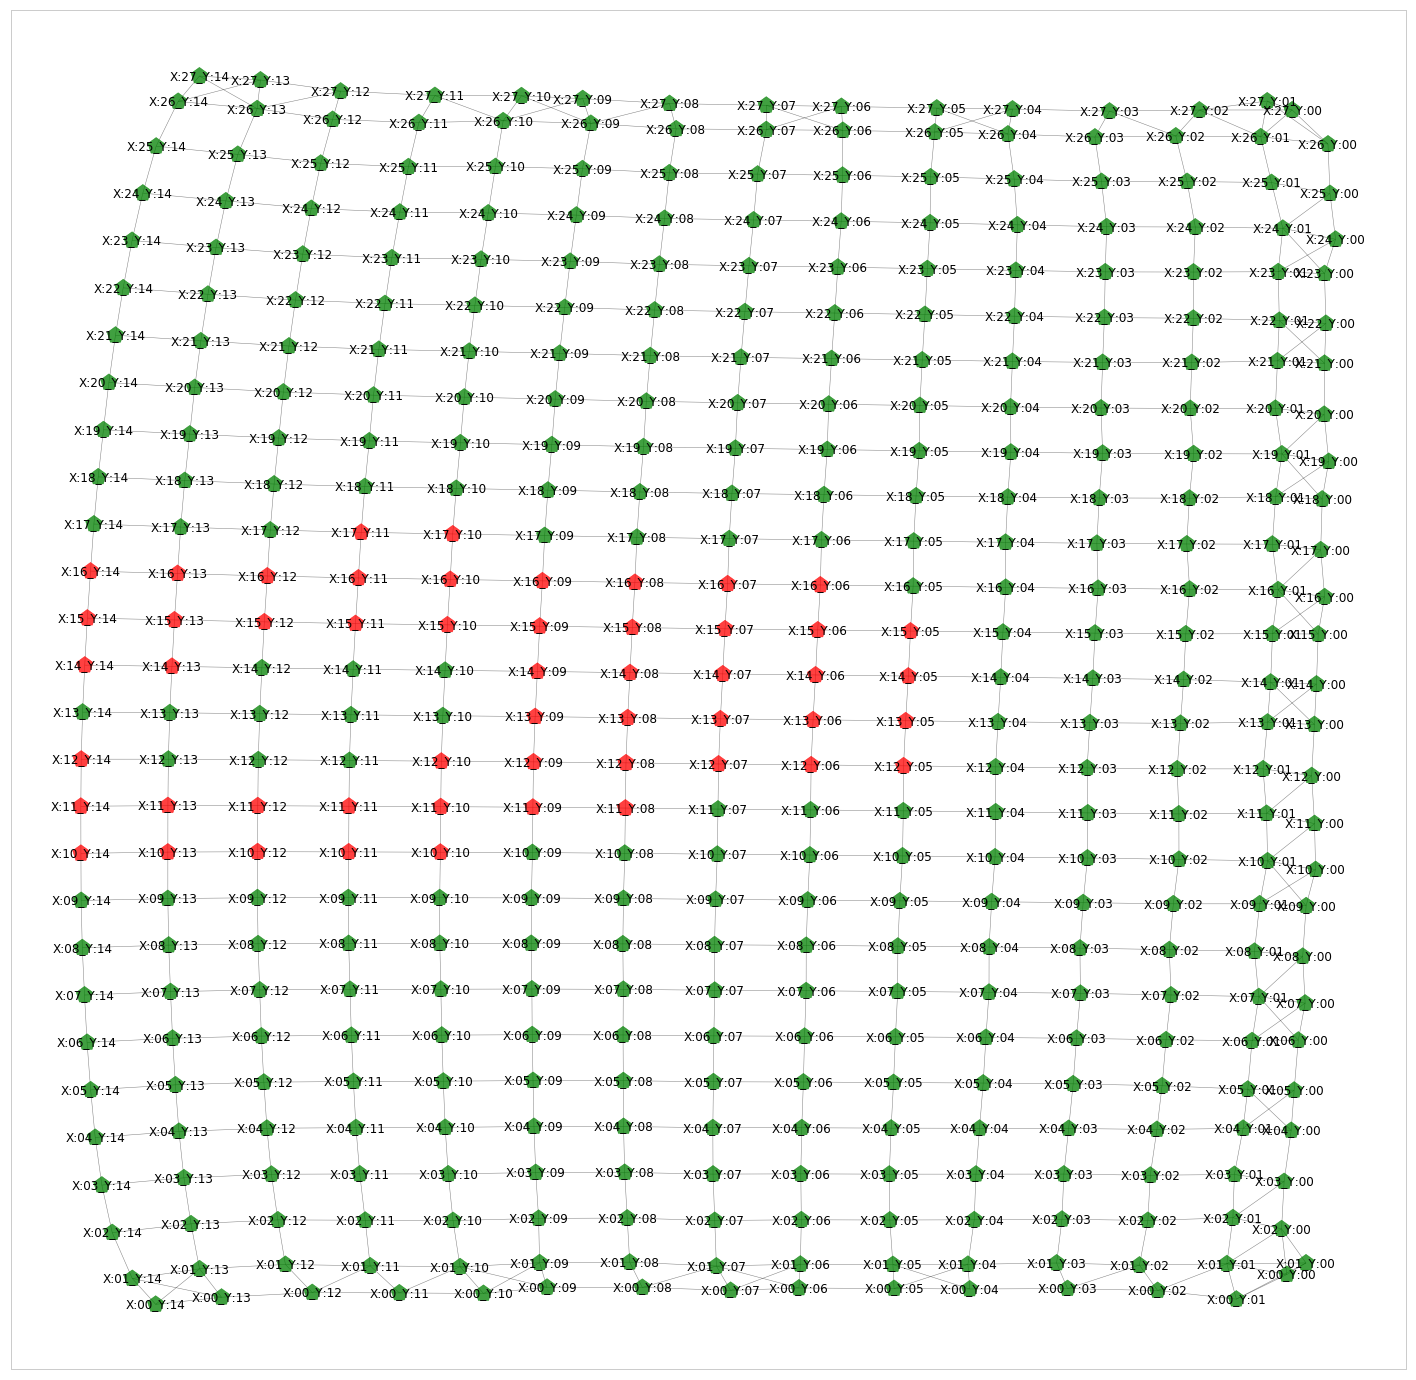

In [6]:
MAX_NODE = 28*15
G = nx.from_scipy_sparse_matrix(adj[:MAX_NODE, :MAX_NODE])
for k, val in zip(G.nodes, X_train[0]):
    G.nodes[k]['label'] = node_id[k]
    G.nodes[k]['color'] = 'red' if val>0 else 'green'
draw_graph_mpl(G);
print(y_train[0])

8


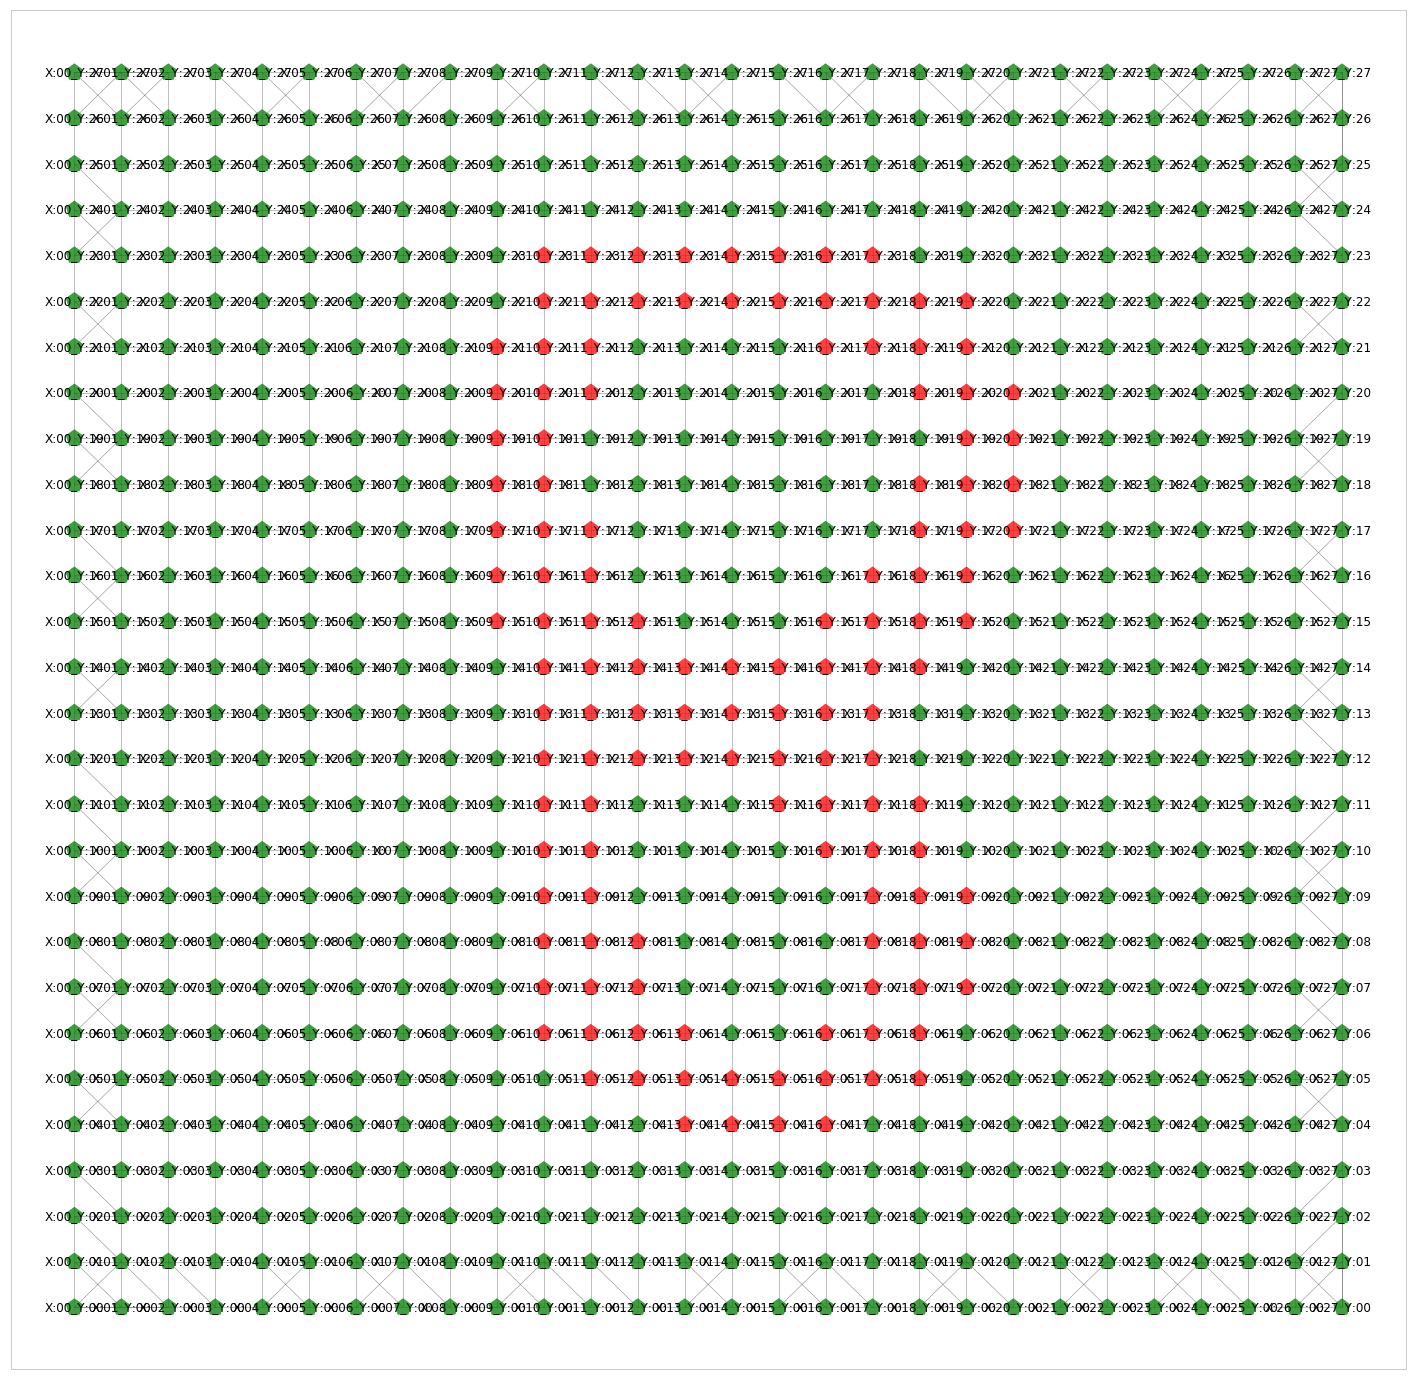

In [7]:
G = nx.from_scipy_sparse_matrix(adj)
for k, val in zip(G.nodes, X_train[1]):
    G.nodes[k]['label'] = node_id[k]
    G.nodes[k]['color'] = 'red' if val>0 else 'green'
draw_graph_mpl(G, pos=np.stack([xx.ravel(), yy.ravel()], -1));
print(y_train[1])

## Flip some edges

6


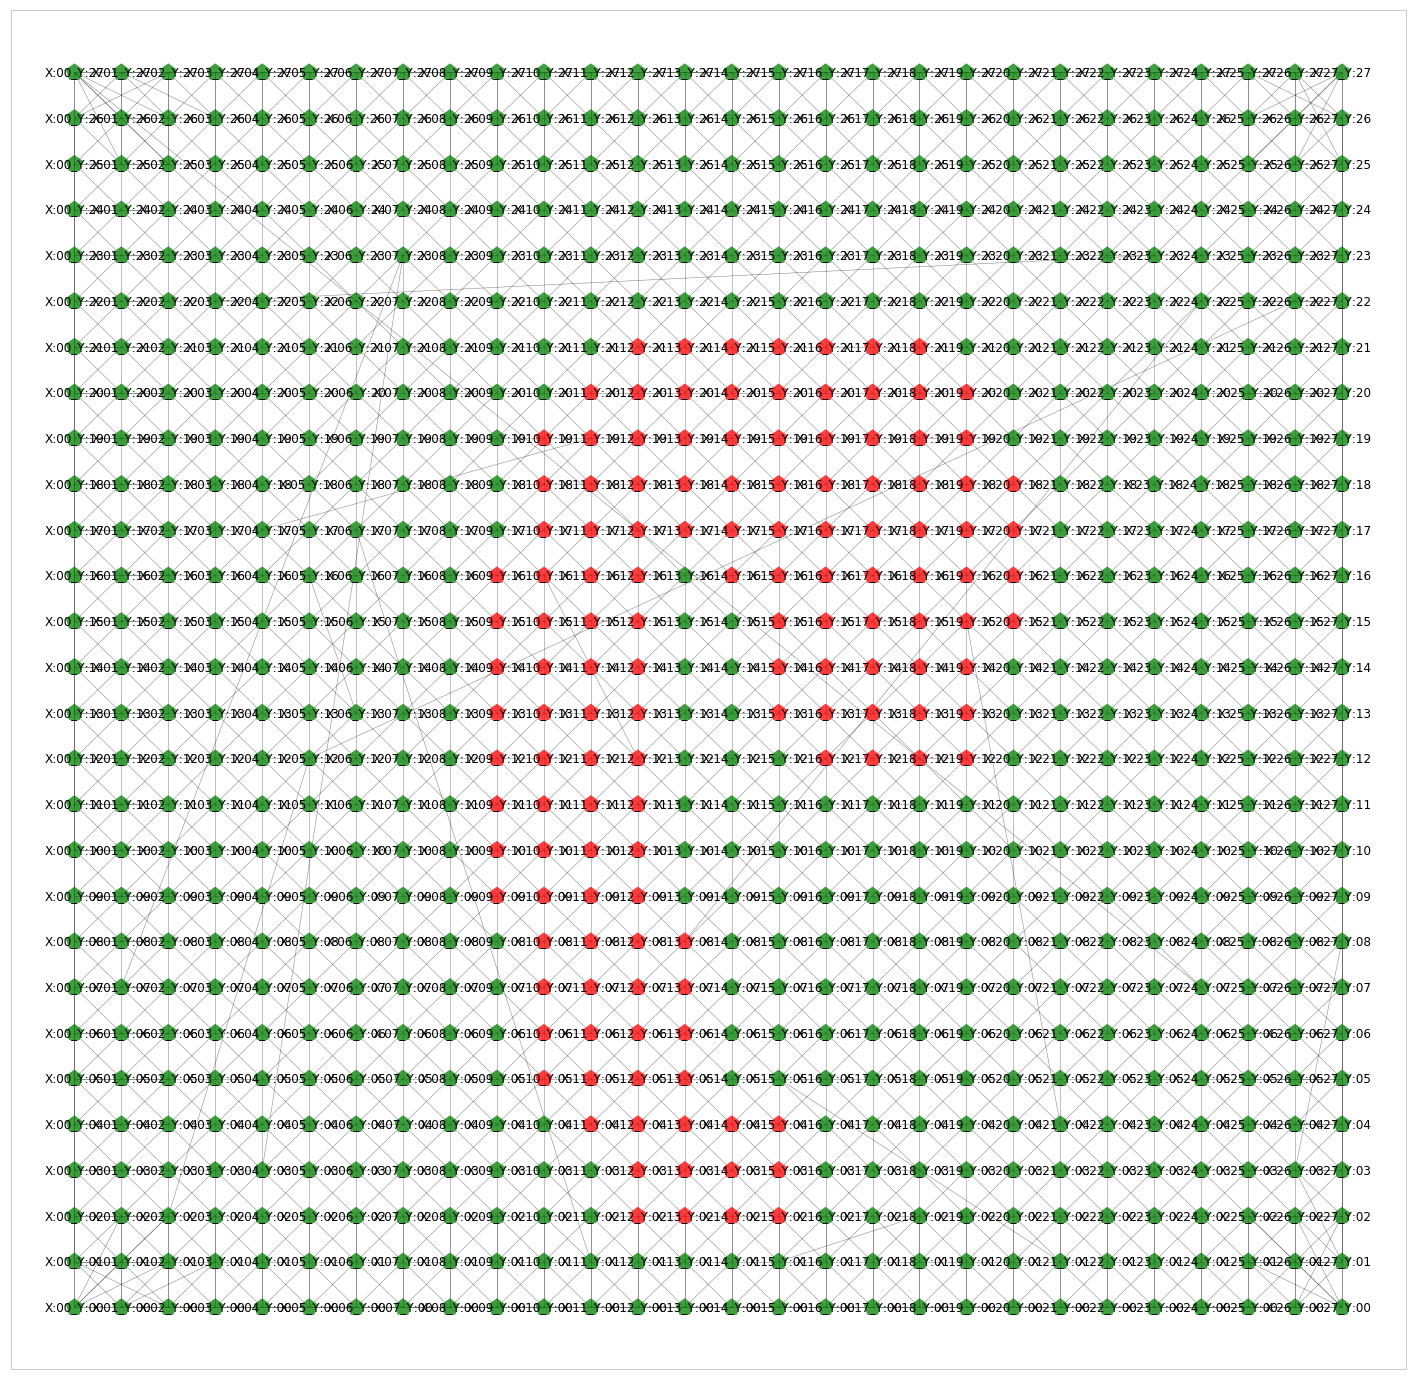

In [8]:
X_train, y_train, X_val, y_val, X_test, y_test, adj = load_data(noise_level=15/784**2, k=8)
G = nx.from_scipy_sparse_matrix(adj)
for k, val in zip(G.nodes, X_train[1]):
    G.nodes[k]['label'] = node_id[k]
    G.nodes[k]['color'] = 'red' if val>0 else 'green'
draw_graph_mpl(G, pos=np.stack([xx.ravel(), yy.ravel()], -1));
print(y_train[1])

# Create Edge Graph for Each Image
And only include points above a threshold

In [9]:
(X_train, y_train), (X_test, y_test) = m.load_data()

In [10]:
def _grid_coordinates_from_img(in_img, threshold):
    """
    Returns 2D coordinates for a square grid of equally spaced nodes.
    :param side: int, the side of the grid (i.e., the grid has side * side nodes).
    :return: np.array of shape (side * side, 2).
    """
    x = np.linspace(0, 1, in_img.shape[0], dtype=np.float32)
    y = np.linspace(0, 1, in_img.shape[1], dtype=np.float32)
    xx, yy = np.meshgrid(x, y)
    z = np.stack([
        xx[in_img>threshold].ravel(),
        yy[in_img>threshold].ravel(),
        in_img[in_img>threshold].ravel(),
    ], -1)
    z = z[np.argsort(-z[:, 2]), :] # sort by pixel value
    return z

def _mnist_img_grid_graph(in_img, k, threshold=0.5):
    """
    Get the adjacency matrix for the KNN graph.
    :param k: int, number of neighbours for each node;
    :return:
    """
    X = _grid_coordinates_from_img(in_img, threshold=threshold)
    A = _get_adj_from_data(
        X[:, :2], k, mode='distance', metric='euclidean', include_self=False
    )
    return A, X

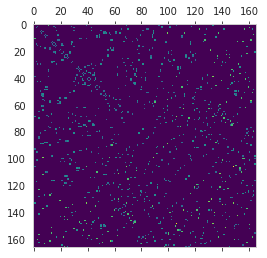

In [11]:
adj, vec = _mnist_img_grid_graph(X_train[0].reshape(28, 28), 6, threshold=0.0)
plt.matshow(adj.todense(), cmap='viridis')

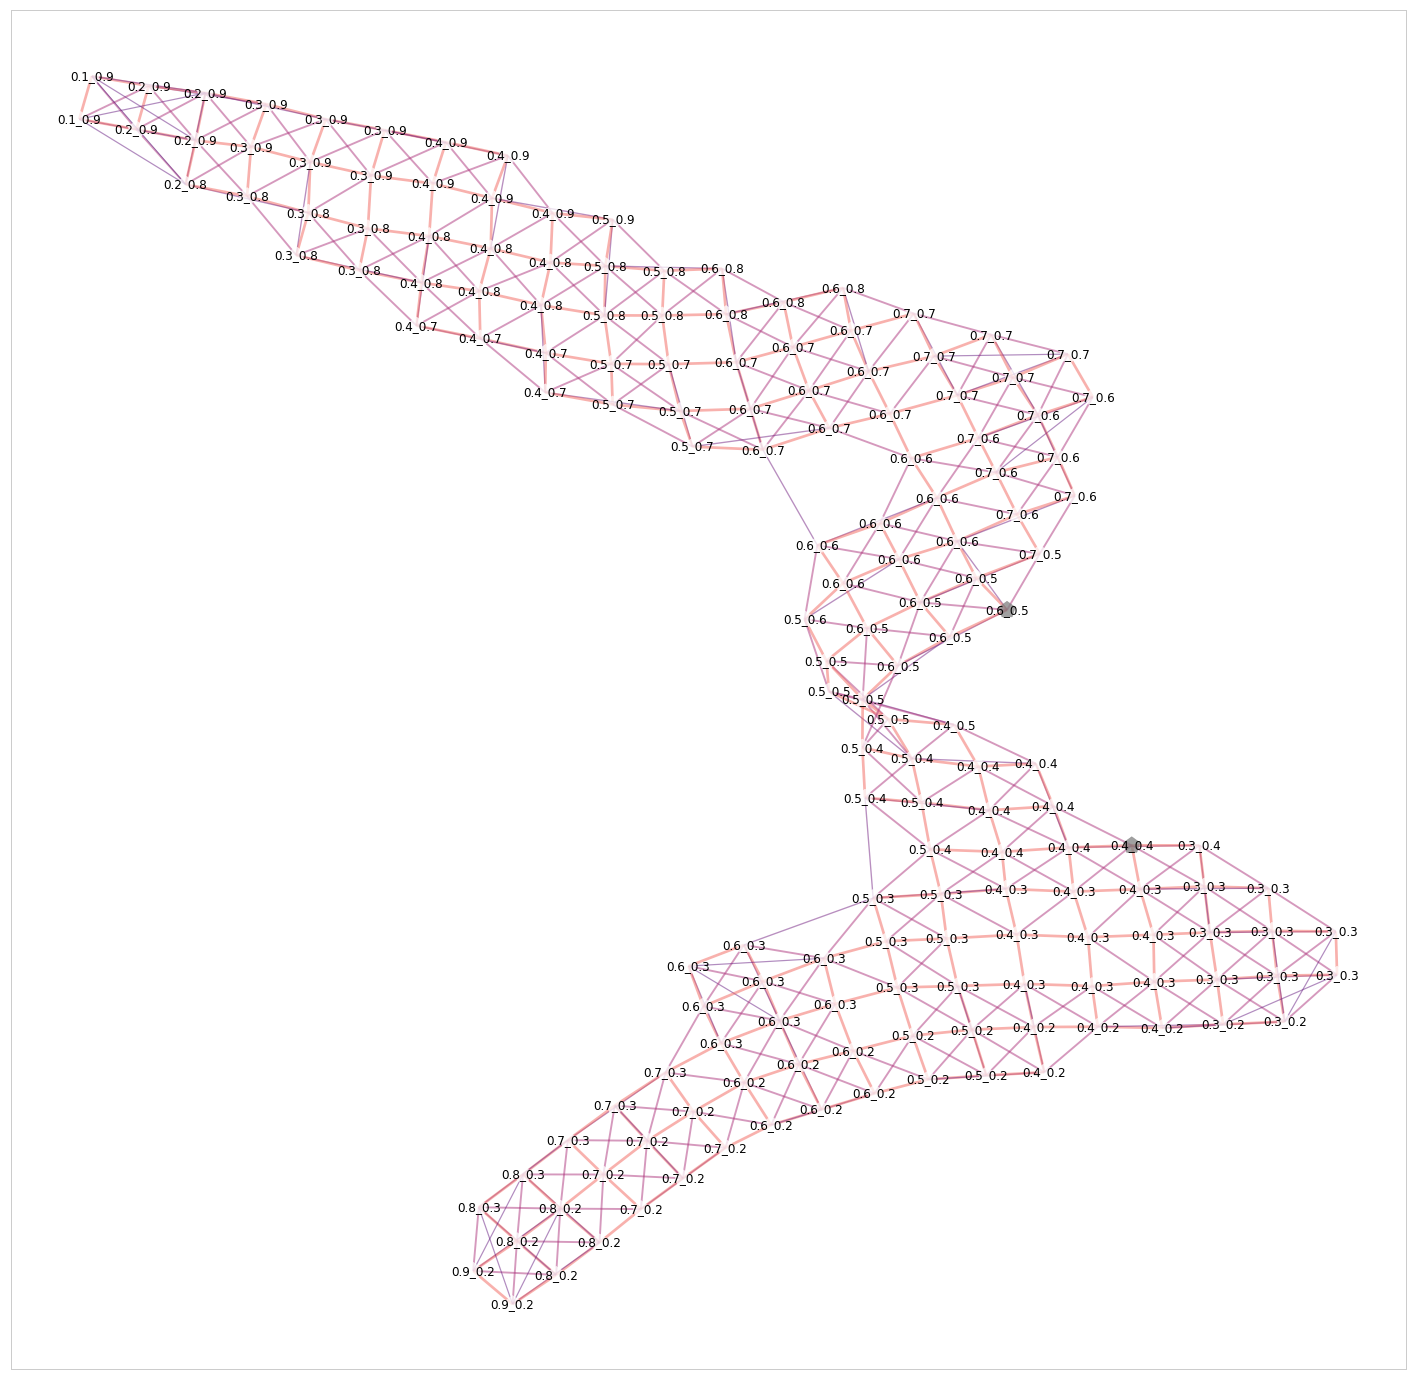

In [12]:
G = nx.from_scipy_sparse_matrix(adj)
for k, (xval, yval, cval) in zip(G.nodes, vec):
    G.nodes[k]['label'] = '{:2.1}_{:2.1}'.format(xval, yval)
    G.nodes[k]['color'] = plt.cm.gray(cval/2)
for e in G.edges():
    G.edges[e]['width'] = 0.1/G.edges[e]['weight']
    G.edges[e]['color'] = plt.cm.magma(0.025/G.edges[e]['weight'])
draw_graph_mpl(G);

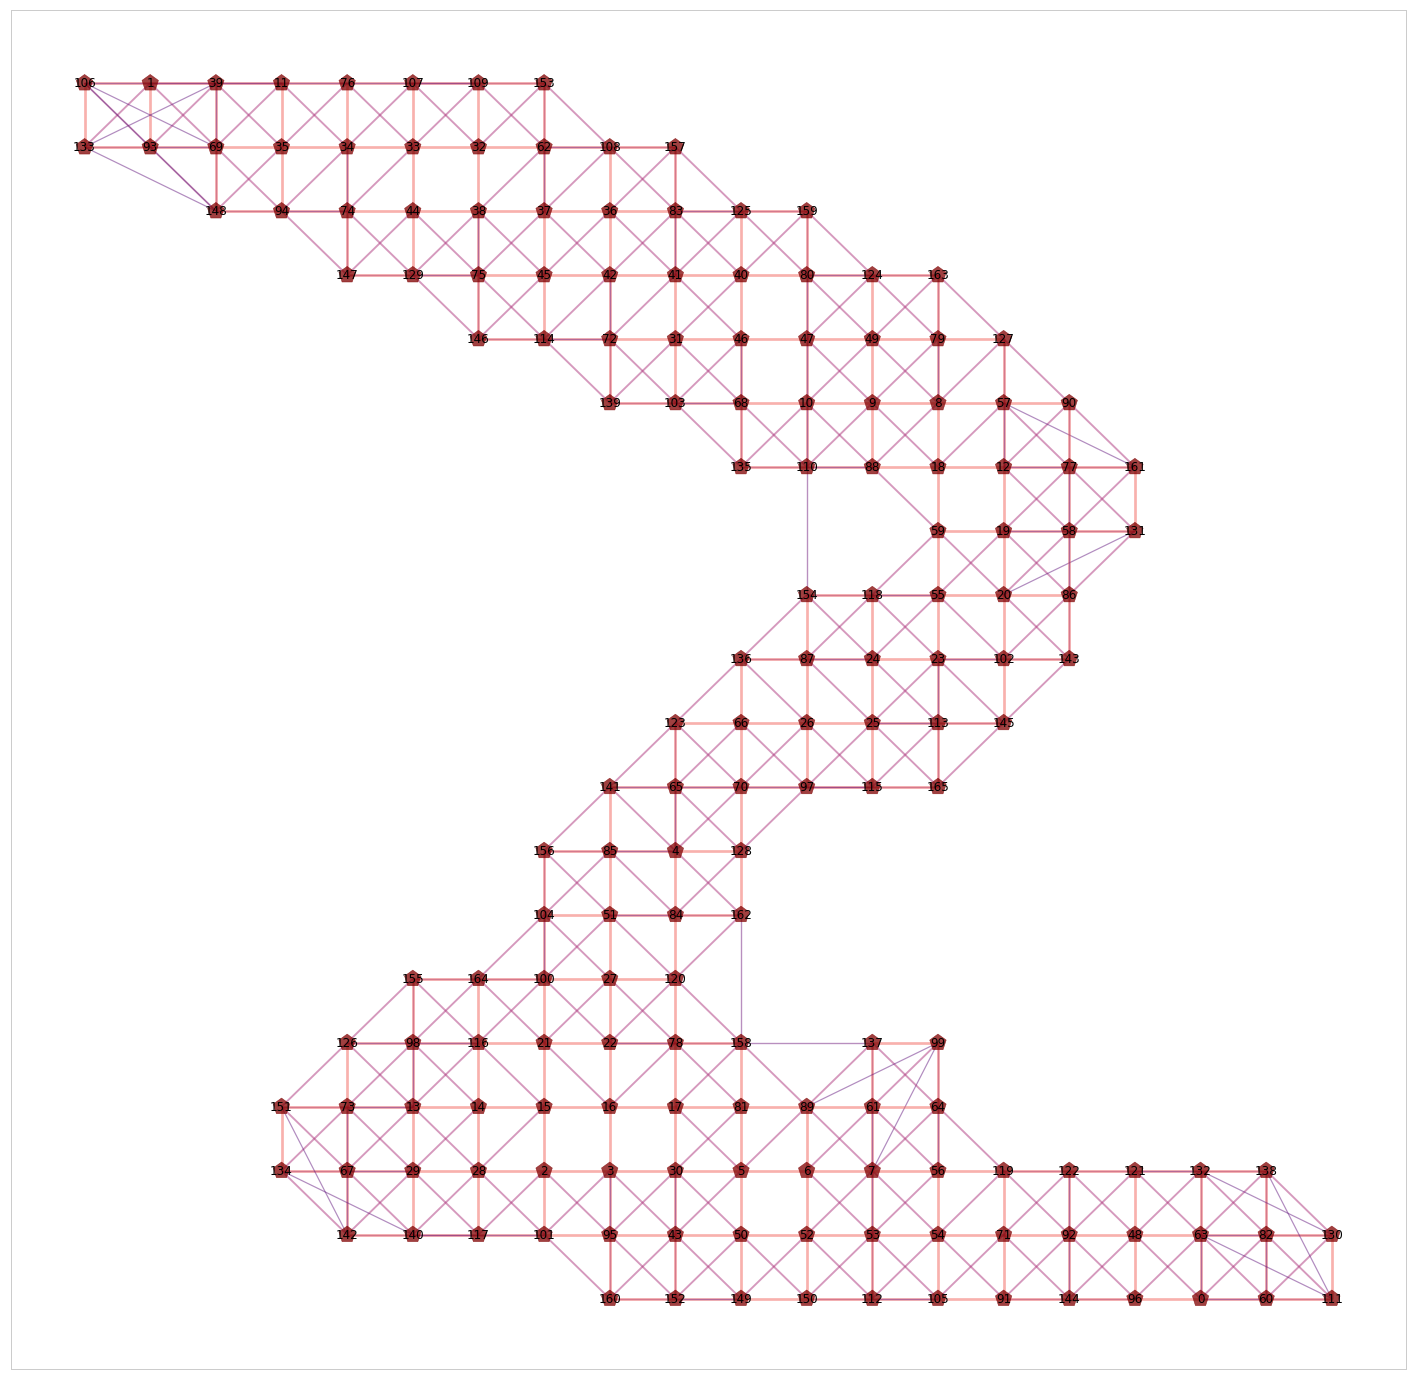

In [13]:
G = nx.from_scipy_sparse_matrix(adj)
for k, (xval, yval, cval) in zip(G.nodes, vec):
    G.nodes[k]['color'] = plt.cm.jet(cval)
for e in G.edges():
    G.edges[e]['width'] = 0.1/G.edges[e]['weight']
    G.edges[e]['color'] = plt.cm.magma(0.025/G.edges[e]['weight'])
draw_graph_mpl(G, pos=vec[:, :2]);

In [14]:
from tqdm import tqdm
def _package_images(img_stack, k, max_nodes):
    X_feat = np.zeros((img_stack.shape[0], max_nodes, 3), dtype='float32')
    X_adj = np.zeros((img_stack.shape[0], max_nodes, max_nodes), dtype='float32')
    for i, x in enumerate(tqdm(img_stack)):
        adj_vec, feat_vec = _mnist_img_grid_graph(x/255.0, k)
        c_len = min(feat_vec.shape[0], max_nodes)
        X_feat[i, :c_len] = feat_vec[:c_len]
        X_adj[i, :c_len, :c_len] = adj_vec.todense()[:c_len, :c_len]
    return X_feat, [sp.csr_matrix(x) for x in X_adj] # list of sparse matrices

def load_disjoint_data(k=8, max_nodes=200, random_state=None):
    """
    Loads the MNIST dataset and a K-NN graph to perform graph signal
    classification, as described by [Defferrard et al. (2016)](https://arxiv.org/abs/1606.09375).
    The K-NN graph is statically determined from a regular grid of pixels using
    the 2d coordinates.

    The node features of each graph are the MNIST digits vectorized and rescaled
    to [0, 1].
    Two nodes are connected if they are neighbours according to the K-NN graph.
    Labels are the MNIST class associated to each sample.

    :param k: int, number of neighbours for each node;

    :return:
        - X_train, y_train: training node features and labels;
        - X_val, y_val: validation node features and labels;
        - X_test, y_test: test node features and labels;
        - adj_train, adj_val, adj_test: adjacency matrix of the grid;
    """
    (img_train, y_train), (img_test, y_test) = m.load_data()
    X_train, adj_train = _package_images(img_train, k=k, max_nodes=max_nodes)
    X_train, X_val, y_train, y_val, adj_train, adj_val = train_test_split(X_train, y_train, adj_train, test_size=10000, random_state=random_state)
    X_test, adj_test = _package_images(img_test, k=k, max_nodes=max_nodes)
    return (X_train, y_train, adj_train), (X_val, y_val, adj_val), (X_test, y_test, adj_test)

In [15]:
(X_train, y_train, adj_train), (X_val, y_val, adj_val), (X_test, y_test, adj_test) = load_disjoint_data()

100%|██████████| 10000/10000 [00:21<00:00, 463.26it/s]


### Patterns in the Adjacency
Here we show the first 64 adjacency matrices to see if we can see patterns

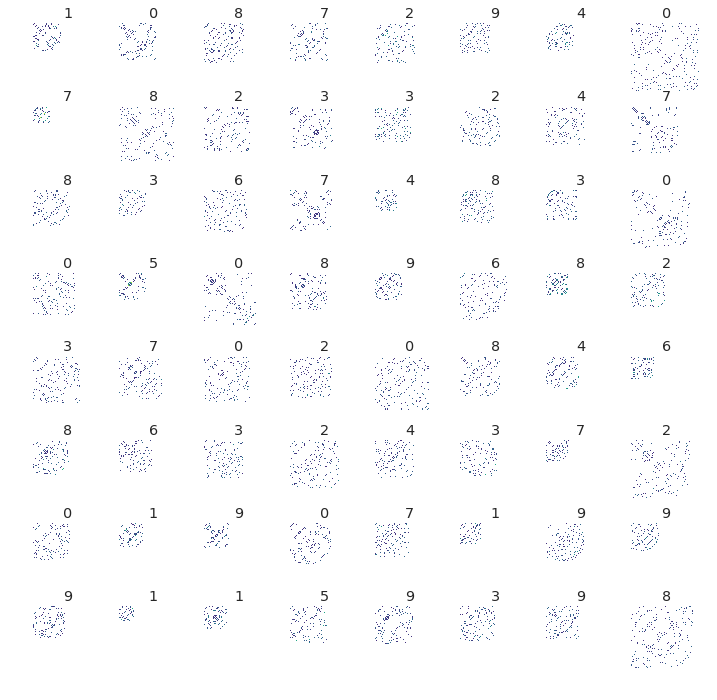

In [16]:
fig, m_axs = plt.subplots(8, 8, figsize=(12, 12))
for i, c_ax in enumerate(m_axs.flatten()):
    c_img = adj_train[i].todense()
    c_img[c_img==0] = np.NAN
    c_ax.imshow(c_img, cmap='viridis', vmin=0, vmax=0.25)
    c_ax.set_title(y_train[i])
    c_ax.axis('off')

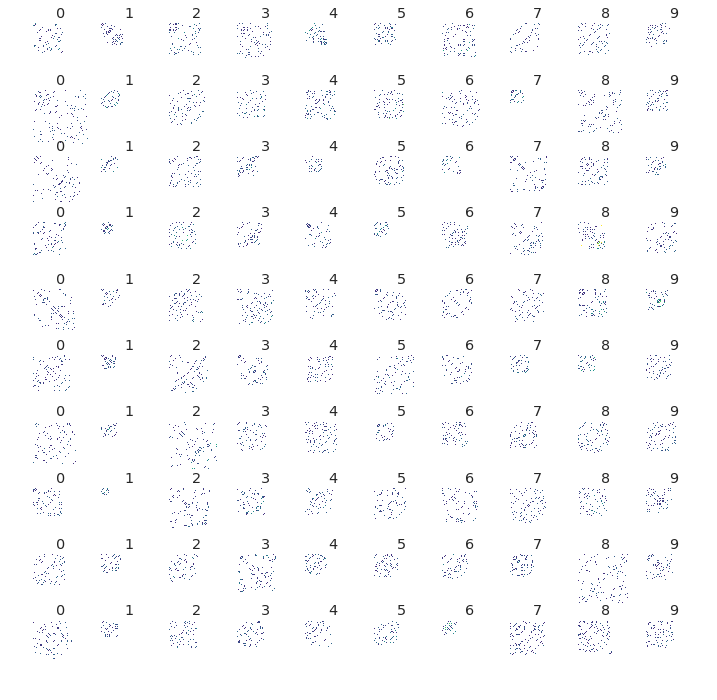

In [17]:
fig, m_axs = plt.subplots(10, 10, figsize=(12, 12))
for i, n_axs in enumerate(m_axs.T):
    c_idx, = np.where(y_train==i)
    for j, c_ax in zip(c_idx, n_axs):
        c_img = adj_train[j].todense()
        c_img[c_img==0] = np.NAN
        c_ax.imshow(c_img, cmap='viridis', vmin=0, vmax=0.25)
        c_ax.set_title(y_train[j])
        c_ax.axis('off')

### Write Outputs to Disk

In [18]:
import h5py
with h5py.File('disjoint_mnist.h5', 'w') as h:
    for (x,y,a_list), c_seg in zip([(X_train, y_train, adj_train), 
                               (X_val, y_val, adj_val), 
                               (X_test, y_test, adj_test)], ['train', 'val', 'test']):
        c_group = h.create_group(c_seg)
        c_group.create_dataset('feature', data=x, dtype='float32', compression='gzip')
        adj_dist = c_group.create_dataset('adjacency_distance', 
                                          shape=(x.shape[0],)+a_list[0].shape, 
                                          chunks=(1,)+a_list[0].shape, 
                                          dtype='float32', 
                                          compression='gzip')
        for i, c_a in enumerate(tqdm(a_list)):
            adj_dist[i] = c_a.todense()
        c_group.create_dataset('label', data=y)

100%|██████████| 10000/10000 [00:18<00:00, 554.10it/s]


In [19]:
!ls -lh disjoint_mnist.h5

-rw-r--r-- 1 root root 212M Dec  4 14:02 disjoint_mnist.h5


In [20]:
with h5py.File('disjoint_mnist.h5', 'r') as h:
    for k1, v1 in h.items():
        for k2, v2 in v1.items():
            print(k1, k2, v2.shape)

test adjacency_distance (10000, 200, 200)
test feature (10000, 200, 3)
test label (10000,)
train adjacency_distance (50000, 200, 200)
train feature (50000, 200, 3)
train label (50000,)
val adjacency_distance (10000, 200, 200)
val feature (10000, 200, 3)
val label (10000,)
